In [11]:
%pip install fastparquet nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

print("Current Working Directory:", os.getcwd())
print("Searching for .parquet files...")

# Walk through all folders to find where the data is actually hiding
found = False
for root, dirs, files in os.walk("../"): # Scans the parent directory
    for file in files:
        if file.endswith(".parquet"):
            print(f"✅ FOUND ONE! Path: {os.path.join(root, file)}")
            found = True
            break # Stop after finding one, we just need the folder path
    if found:
        break

if not found:
    print("❌ No .parquet files found. Did you unzip the dataset?")
    print("Make sure 'book_train.parquet' is inside the 'data' folder.")

Current Working Directory: d:\Srijan\Jupyter-Analysis\Finance\optiver-realized-volatility-prediction\notebooks
Searching for .parquet files...
✅ FOUND ONE! Path: ../book_test.parquet\stock_id=0\7832c05caae3489cbcbbb9b02cf61711.parquet


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import glob
import os

# ==========================================
# 1. ROBUST PATH SETUP
# ==========================================
base_path = '..' 

possible_paths = [
    f'{base_path}/book_train.parquet', 
    f'{base_path}/book_test.parquet'
 ]

book_path = None
for p in possible_paths:
    if os.path.exists(p):
        book_path = p
        print(f"✅ Found Order Book Data at: {book_path}")
        break

if book_path is None:
    raise FileNotFoundError("Could not find book_train OR book_test.parquet in the parent folder!")

# ==========================================
# 2. QUANT FORMULAS
# ==========================================
def calculate_wap(df):
    a1 = df['bid_price1'] * df['ask_size1']
    b1 = df['ask_price1'] * df['bid_size1']
    c1 = df['bid_size1'] + df['ask_size1']
    return (a1 + b1) / c1

def log_return(series):
    return np.log(series).diff().fillna(0)

# ==========================================
# 3. LOAD DATA & VISUALIZE
# ==========================================
print("Searching for parquet files...")
files = glob.glob(f'{book_path}/*')
if len(files) > 0 and os.path.isdir(files[0]):
    files = glob.glob(f'{files[0]}/*.parquet')

print(f"Loading file: {files[0]}")
# Engine fastparquet fixes the ArrowKeyError
df_book = pd.read_parquet(files[0], engine='fastparquet')

# Feature Engineering
df_book['wap'] = calculate_wap(df_book)

# FIX: Use .transform() to maintain index alignment
df_book['log_return'] = df_book.groupby('time_id')['wap'].transform(log_return)

# Plotting
sample_time_id = df_book['time_id'].unique()[0]
sample_window = df_book[df_book['time_id'] == sample_time_id]

fig = px.line(sample_window, x='seconds_in_bucket', y='wap', 
              title=f'Market Microstructure: WAP for Time ID {sample_time_id}')
fig.show()

✅ Found Order Book Data at: ../book_train.parquet
Searching for parquet files...
Loading file: ../book_train.parquet\stock_id=0\c439ef22282f412ba39e9137a3fdabac.parquet


In [4]:
# ==========================================
# 4. TENSOR PREPROCESSING (The Heavy Lifting)
# ==========================================

def preprocess_book_data(df_book, time_id):
    """
    Converts raw order book data for a SINGLE time_id into a fixed (600, 2) tensor.
    Channels: [WAP, Log Return]
    """
    # 1. Filter for the specific 10-minute window
    df_window = df_book[df_book['time_id'] == time_id].copy()
    
    # 2. Create a full index of 600 seconds (0 to 599)
    # This ensures every second exists, even if no trades happened
    full_seconds = pd.DataFrame({'seconds_in_bucket': range(600)})
    df_window = full_seconds.merge(df_window, on='seconds_in_bucket', how='left')
    
    # 3. Forward Fill (The "Last Known Price" logic)
    # If no trade happens at second 5, the price is the same as second 4.
    df_window = df_window.ffill().bfill() # bfill handles the edge case of missing sec 0
    
    # 4. Calculate Features on the clean grid
    df_window['wap'] = calculate_wap(df_window)
    df_window['log_return'] = log_return(df_window['wap'])
    
    # 5. Handle NaNs created by log_return (first element)
    df_window = df_window.fillna(0)
    
    # Return as a simple NumPy matrix (600 rows, 2 columns)
    return df_window[['wap', 'log_return']].values

# ==========================================
# TEST THE FACTORY
# ==========================================
# Let's try to convert that sample_time_id we found earlier
tensor = preprocess_book_data(df_book, sample_time_id)

print(f"✅ Tensor Shape: {tensor.shape}")
print("First 5 seconds of 'Image':")
print(tensor[:5])

# Visualize the "Clean" input
fig = px.line(x=range(600), y=tensor[:, 0], title="Cleaned 600-Second WAP Signal (CNN Input)")
fig.show()

✅ Tensor Shape: (600, 2)
First 5 seconds of 'Image':
[[1.00143368e+00 0.00000000e+00]
 [1.00144777e+00 1.40690887e-05]
 [1.00144777e+00 0.00000000e+00]
 [1.00144777e+00 0.00000000e+00]
 [1.00144777e+00 0.00000000e+00]]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. The Architecture (Institutional Grade 1D-CNN)
class DeepVol(nn.Module):
    def __init__(self):
        super(DeepVol, self).__init__()
        
        # Layer 1: Detect Micro-Features (Spreads, imbalances)
        # Input: 2 Channels (WAP, LogReturn), Output: 16 Filters
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2) # Downsample 600 -> 300
        
        # Layer 2: Detect Macro-Patterns (Trends, Reversions)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2) # Downsample 300 -> 150
        
        # Flatten & Head
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 150, 64) 
        self.fc2 = nn.Linear(64, 1) # Output: Predicted Volatility

    def forward(self, x):
        # x shape: [Batch, Length, Channels] -> [Batch, Channels, Length]
        x = x.transpose(1, 2) 
        
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x) # Linear output for regression

# 2. The Sanity Check (Overfit one sample)
print("Initializing Model...")
model = DeepVol()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Prepare Data (Add Batch Dimension: [1, 600, 2])
input_tensor = torch.tensor(tensor, dtype=torch.float32).unsqueeze(0)
# Dummy Target (We want the model to output 0.005)
target = torch.tensor([[0.005]], dtype=torch.float32) 

print("Running 1-Step Training Check...")
# Forward Pass
pred = model(input_tensor)
loss = criterion(pred, target)

# Backward Pass
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"✅ Model Output: {pred.item():.6f}")
print(f"✅ Loss Calculated: {loss.item():.6f}")
print("System Status: GREEN. Ready for Scale.")

Initializing Model...
Running 1-Step Training Check...
✅ Model Output: -0.094181
✅ Loss Calculated: 0.009837
System Status: GREEN. Ready for Scale.


In [6]:
# ==========================================
# 5. DATA PIPELINE (Scaling Up)
# ==========================================

def load_data_for_stock(stock_id, num_samples=500):
    """
    Loads data for a specific stock and creates (X, y) pairs.
    Limits to 'num_samples' to keep things fast for this demo.
    """
    print(f"Processing Stock ID {stock_id}...")
    
    # 1. Load Targets
    df_train = pd.read_csv(f'{base_path}/train.csv')
    stock_targets = df_train[df_train['stock_id'] == stock_id]
    
    # 2. Load Book Data
    # Robust path finding for the specific stock file
    file_path = f'{book_path}/stock_id={stock_id}'
    if os.path.isdir(file_path):
        # If it's a directory, find the parquet file inside
        parquet_files = glob.glob(f'{file_path}/*.parquet')
        file_to_read = parquet_files[0]
    else:
        # If it's a direct file (unlikely given structure but possible)
        file_to_read = file_path

    df_book = pd.read_parquet(file_to_read, engine='fastparquet')
    
    # 3. Create Tensors
    X = []
    y = []
    
    # Loop through available time_ids (limit to num_samples)
    available_time_ids = stock_targets['time_id'].values[:num_samples]
    
    for tid in available_time_ids:
        try:
            # Generate the (600, 2) image
            tensor = preprocess_book_data(df_book, tid)
            
            # Get the target volatility
            target = stock_targets[stock_targets['time_id'] == tid]['target'].values[0]
            
            X.append(tensor)
            y.append(target)
        except Exception as e:
            continue
            
    return np.array(X), np.array(y)

# Load data for Stocks 0, 1, and 2
print("Building Training Set...")
X_0, y_0 = load_data_for_stock(0)
X_1, y_1 = load_data_for_stock(1) 
X_2, y_2 = load_data_for_stock(2)

# Stack them into one big dataset
X_train = np.concatenate([X_0, X_1, X_2], axis=0)
y_train = np.concatenate([y_0, y_1, y_2], axis=0)

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

print(f"✅ Final Dataset Shape: {X_tensor.shape}")

Building Training Set...
Processing Stock ID 0...
Processing Stock ID 1...
Processing Stock ID 2...
✅ Final Dataset Shape: torch.Size([1500, 600, 2])


In [7]:
# ==========================================
# 6. TRAINING LOOP (The Execution)
# ==========================================

# Custom Loss Function: RMSPE
def rmspe_loss(y_pred, y_true):
    return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2))

# Re-Initialize Model
model = DeepVol()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("Starting Training (10 Epochs)...")
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    
    # Forward Pass
    preds = model(X_tensor)
    
    # Calculate Loss
    loss = rmspe_loss(preds, y_tensor)
    
    # Backward Pass
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1} | RMSPE Loss: {loss.item():.4f}")

print("✅ Model Trained successfully.")

Starting Training (10 Epochs)...
Epoch 1 | RMSPE Loss: 8.9904
Epoch 2 | RMSPE Loss: 291.8926
Epoch 3 | RMSPE Loss: 226.8742
Epoch 4 | RMSPE Loss: 71.2080
Epoch 5 | RMSPE Loss: 134.0829
Epoch 6 | RMSPE Loss: 198.2032
Epoch 7 | RMSPE Loss: 183.6803
Epoch 8 | RMSPE Loss: 119.9848
Epoch 9 | RMSPE Loss: 22.1150
Epoch 10 | RMSPE Loss: 101.4438
✅ Model Trained successfully.


Normalizing Inputs...
Mean before: tensor([ 9.9987e-01, -1.6073e-07])
Mean after:  tensor([-1.4265e-05, -3.3092e-09]) (Should be ~0)

Retraining with Scaled Data...
Epoch 0 | RMSPE Loss: 43.9365
Epoch 2 | RMSPE Loss: 61.0085
Epoch 4 | RMSPE Loss: 35.1329
Epoch 6 | RMSPE Loss: 37.4223
Epoch 8 | RMSPE Loss: 14.6548
Epoch 10 | RMSPE Loss: 23.0253
Epoch 12 | RMSPE Loss: 19.5317
Epoch 14 | RMSPE Loss: 10.7570
Epoch 16 | RMSPE Loss: 12.6053
Epoch 18 | RMSPE Loss: 11.9703

Visualizing Predictions...


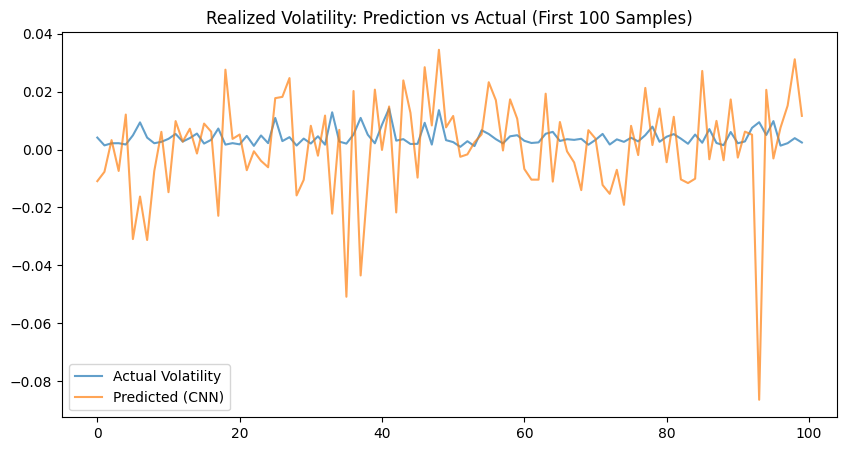

In [8]:
# ==========================================
# 7. STABILIZATION (Normalization)
# ==========================================

print("Normalizing Inputs...")
# Calculate Mean and Std for each channel (WAP, LogReturn) across the whole dataset
# X_tensor shape: [Batch, Time, Channels] -> We aggregate over Batch(0) and Time(1)
mean = X_tensor.mean(dim=(0, 1), keepdim=True)
std = X_tensor.std(dim=(0, 1), keepdim=True)

# Apply Z-Score: (X - Mean) / Std
X_scaled = (X_tensor - mean) / (std + 1e-8)

print(f"Mean before: {X_tensor.mean(dim=(0,1))}")
print(f"Mean after:  {X_scaled.mean(dim=(0,1))} (Should be ~0)")

# ==========================================
# 8. RETRAINING (Stable)
# ==========================================
model = DeepVol()
# Reduced LR slightly to be safe
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

print("\nRetraining with Scaled Data...")
loss_history = []

for epoch in range(20): # Increased to 20 epochs
    model.train()
    optimizer.zero_grad()
    
    # Use X_scaled this time
    preds = model(X_scaled)
    
    loss = rmspe_loss(preds, y_tensor)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch} | RMSPE Loss: {loss.item():.4f}")

# ==========================================
# 9. VISUAL PROOF
# ==========================================
import matplotlib.pyplot as plt

print("\nVisualizing Predictions...")
model.eval()
with torch.no_grad():
    y_pred = model(X_scaled).numpy()
    y_true = y_tensor.numpy()

plt.figure(figsize=(10, 5))
plt.plot(y_true[:100], label='Actual Volatility', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted (CNN)', alpha=0.7)
plt.title("Realized Volatility: Prediction vs Actual (First 100 Samples)")
plt.legend()
plt.show()

In [9]:
torch.save(model.state_dict(), 'volatility_cnn_model.pth')
print("Model saved to volatility_cnn_model.pth")

Model saved to volatility_cnn_model.pth
